In [1]:
import cv2 
import ast
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from os import listdir
import pandas as pd
from scipy.interpolate import interp1d
from scipy import ndimage
#from tools import Tools
import json

In [48]:
possible_interpo = ["linear", "nearest", "zero", "slinear", "quadratic", "cubic’ where ‘zero", "cubic"]
joints=["Right shoulder", "Left shoulder", "Right elbow", "Right wrist","Left elbow", "Left wrist",
        "Right hip", "Right knee", "Right ankle", "Left hip", "Left knee", "Left ankle", "Neck ",
        "Right eye", "Right ear","Left eye", "Left ear"]

def smooth_estelle(x,window_len=6,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """ 
    #print(len(x))
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
        

    if window_len<3:
        return x
    
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    

    #s = np.r_[x[window_len//2-1:0:-1],x,x[-1:-window_len//2:-1],x[-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    #print(w)
    
    y=np.convolve(w/w.sum(),x,mode='same')
    #print(len(y))
    return y

def kalmann(sequence):
    # intial parameters
    n_iter = len(sequence)
    sz = (n_iter,) # size of array
    #x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
    z = sequence #np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 0.1**3 # estimate of measurement variance, change to see effect

    # intial guesses
    xhat[0] = sequence[0]
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]
    return sequence, xhat

from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt

def lowpass(sequence):
    def butter_lowpass(cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / float(nyq)
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a


    def butter_lowpass_filter(data, cutoff, fs, order=5):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y
    return butter_lowpass_filter(sequence, 1, 15)

def plot_interpolations_old_data(example, inter_list, START, END, inter = "linear"):
    RANGE = (END-START)/2
    FRAME = (END+START)/2
    linear = example
    cubic = example
    smooth = example
    kal = example
    ml = example
    not_zer = np.where(example[START:END, 1, 0]!=0)[0]
    print(not_zer)
    N,j, co = example.shape
    smo2 = np.zeros((N*2, j, co))
    indices = np.arange(0, END-START, 1)
    ind_twice = np.arange(0, (END-START)-0.5, 0.5)
    for i in range(12):
        for j in range(2):
            #print(not_zer, example[not_zer+START, i,j], indices)
            #print(not_zer*2, example[not_zer+START, i,j], ind_twice)
            #print(example[not_zer+START, i, j])
            f = interpolate.interp1d(not_zer, example[not_zer+START, i,j], kind=inter)
            cubic[START:END, i, j] = np.round(f(indices), 1)
            new = np.interp(indices, not_zer, example[not_zer+START,i,j])
            new2= interpolate.interp1d(not_zer, example[not_zer+START, i,j], kind=inter)
            linear[START:END, i, j] =  new
            smooth[START:END, i, j] = ndimage.filters.gaussian_filter1d(new, sigma = 3)
            #smo2[(START-RANGE):(END+RANGE)-1, i, j]= np.round(f(ind_twice),1)
            # kal[START:END, i, j] = kalmann(new)[1]
        fig = plt.figure(figsize = (20,10))
        ax = fig.add_subplot(111)
        dic = {"linear": [linear[START:END, i, 0], linear[START:END, i, 1]],
               "kalmann": [kal[START:END, i, 0], kal[START:END, i, 1]],
              "cubic": [cubic[START:END, i, 0], cubic[START:END, i, 1]],
              "gaussian_filter": [smooth[START:END, i, 0], smooth[START:END, i, 1]],
              "ml": [ml[START:END, i, 0], ml[START:END, i, 1]]}
        for kind in inter_list:
            meX = dic[kind][0]
            meY = dic[kind][1]
            plt.plot(meX, meY, label= kind)
            for k in range(START,END):
                if k==FRAME:
                    ax.annotate(str(k), (meX[k-START], meY[k-START]), size=20)
                else:
                    ax.annotate(str(k), (meX[k-START], meY[k-START]))
        plt.title(joints[i])
        plt.grid()
        plt.legend()
        plt.show()

joints=["Right shoulder", "Left shoulder", "Right elbow", "Right wrist","Left elbow", "Left wrist",
        "Right hip", "Right knee", "Right ankle", "Left hip", "Left knee", "Left ankle", "Neck ",
        "Right eye", "Right ear","Left eye", "Left ear"]
def plot_interpolations(example, inter_list):
    linear = example.copy()
    cubic = example.copy()
    smooth = example.copy()
    kal = example.copy()
    estelle = np.array([example.copy() for _ in range(5)])
    print(estelle.shape)
    numpy_inter = example.copy()
    N,j, co = example.shape
    indices = np.arange(0, len(example), 1)
    #ind_twice = np.arange(0, (END-START)-0.5, 0.5)
    windows = ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
    print(len(windows))
    
    for i in range(12):
        for j in range(2):
            not_zer = np.where(example[:, i, j]!=0)[0]
            # print()
            #linear[:, i, j] = interp1d(not_zer, example[not_zer, i,j], kind="linear")(indices)
            #cubic[:, i, j] = interp1d(not_zer, example[not_zer, i,j], kind="cubic")(indices)
            inter = np.interp(indices, not_zer, example[not_zer,i,j])
            numpy_inter[:, i,j ] = inter
            for k in range(len(windows)):
                estelle[k, :,i,j] = smooth_estelle(inter, window_len=12, window = windows[k])
            kal[:, i, j] = lowpass(inter) # kalmann(inter)[1]
            
    smooth = ndimage.filters.gaussian_filter1d(numpy_inter, axis = 0, sigma = 5)
    minus = kal-example
    """
        fig = plt.figure(figsize = (20,10))
        ax = fig.add_subplot(111)
        dic = {"linear": [linear[:, i, 0], linear[:, i, 1]],
               "kalmann": [kal[:, i, 0], kal[:, i, 1]],
              "cubic": [cubic[:, i, 0], cubic[:, i, 1]],
              "gaussian_filter": [smooth[:, i, 0], smooth[:, i, 1]]
              }
        for kind in inter_list:
            meX = dic[kind][0]
            meY = dic[kind][1]
            plt.plot(meX, meY, label= kind)
            for k in range(len(example)):
                #if k==FRAME:
                 #   ax.annotate(str(k), (meX[k], meY[k]), size=20)
                #else:
                ax.annotate(str(k), (meX[k], meY[k]))
        plt.title(joints[i])
        plt.grid()
        plt.legend()
        plt.show()"""
    for i in range(1):
        print("COORDINATE ", i, "\n \n \n")
        plt.figure(figsize=(20,10))
        plt.plot(example[:,:,i])
        plt.title("normal")
        plt.show()

        plt.figure(figsize=(20,10))
        plt.plot(kal[:,:,i])
        plt.title("kalmann")
        plt.show()
            
        plt.figure(figsize=(20,10))
        plt.plot(minus[:,:,i])
        plt.title("minus")
        plt.show()
        """
        plt.figure(figsize=(20,10))
        plt.plot(numpy_inter[:,:,i])
        plt.title("linear")
        plt.show()
        """

        plt.figure(figsize=(20,10))
        plt.plot(smooth[:,:,i])
        plt.title("smooth")
        plt.show()
        

        for k in range(len(estelle)):
            plt.figure(figsize=(20,10))
            plt.plot(estelle[k,:,:,i])
            plt.title("estelle"+windows[k])
            plt.show()

# NEW VIDEOS: Test filtering methods

ausprobieren: Wiener oder Savitzky-Golay filter scipy

(260, 18, 2)
(5, 260, 12, 2)
5
COORDINATE  0 
 
 



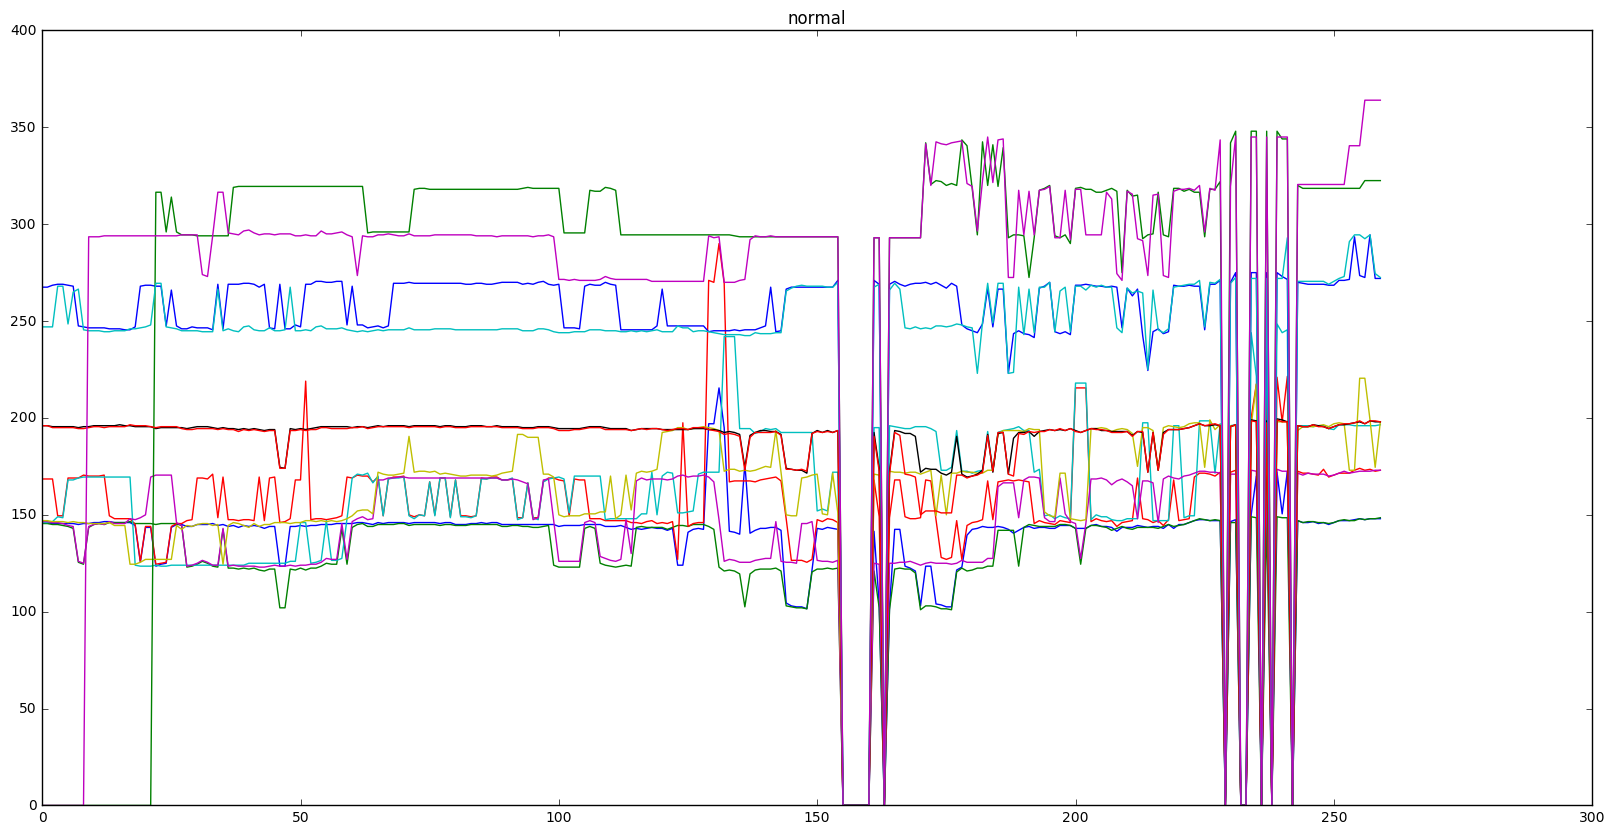

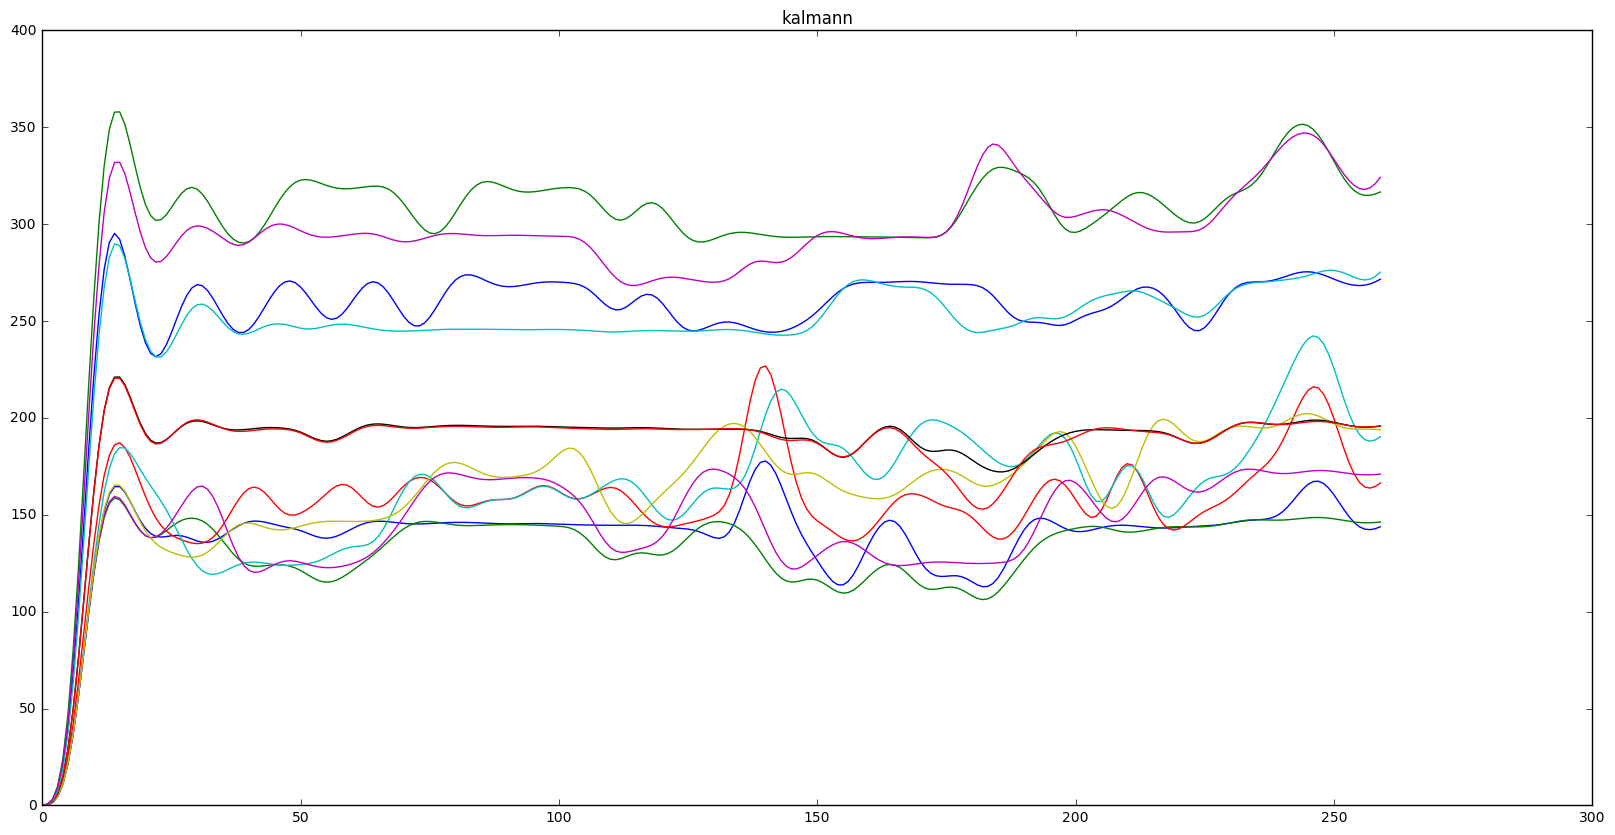

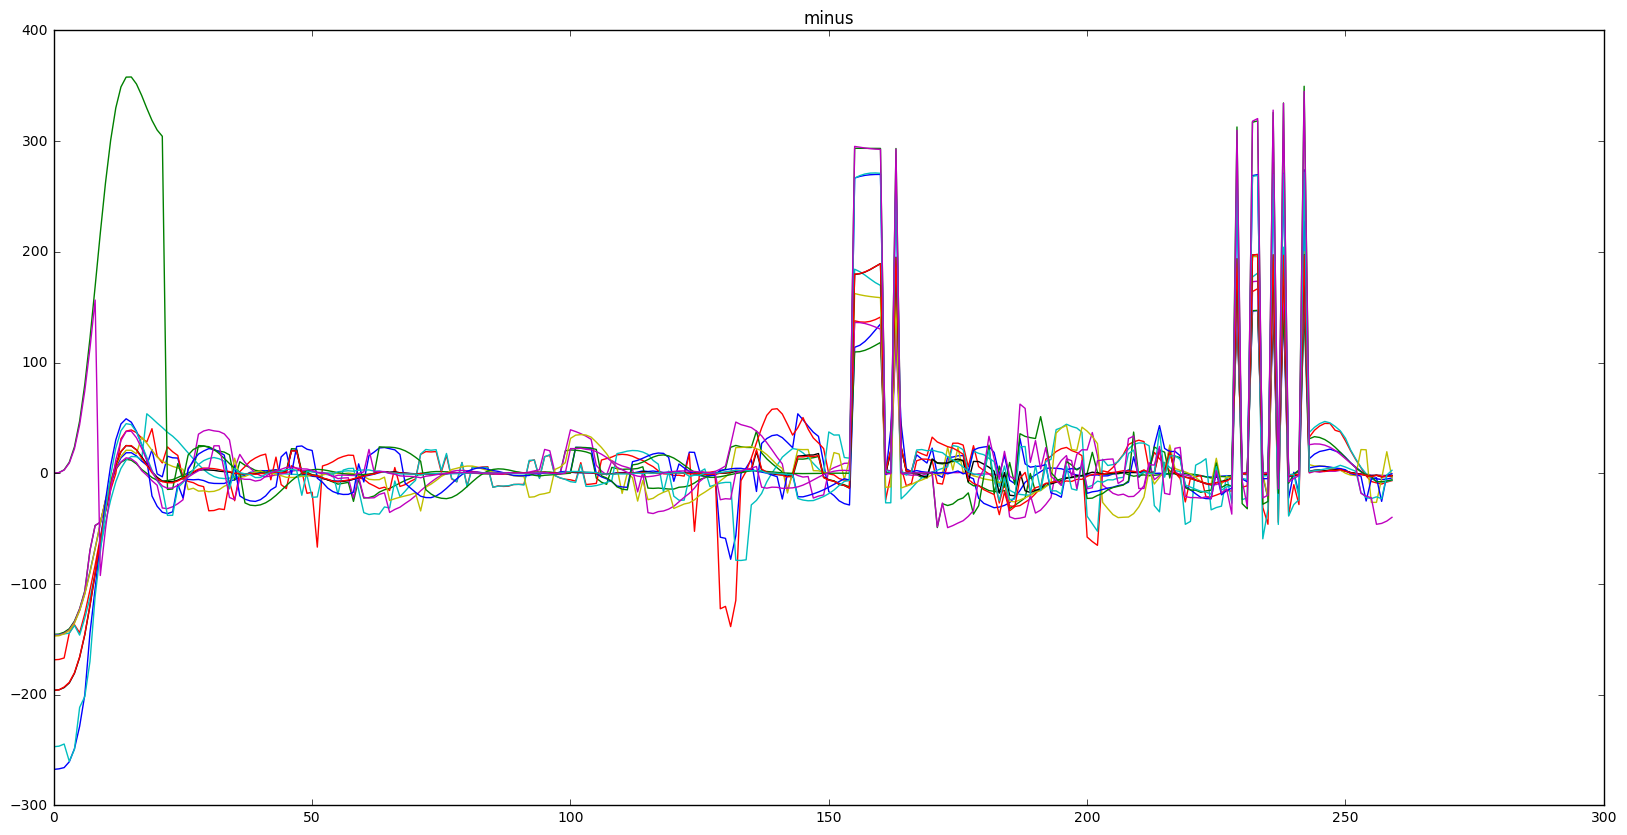

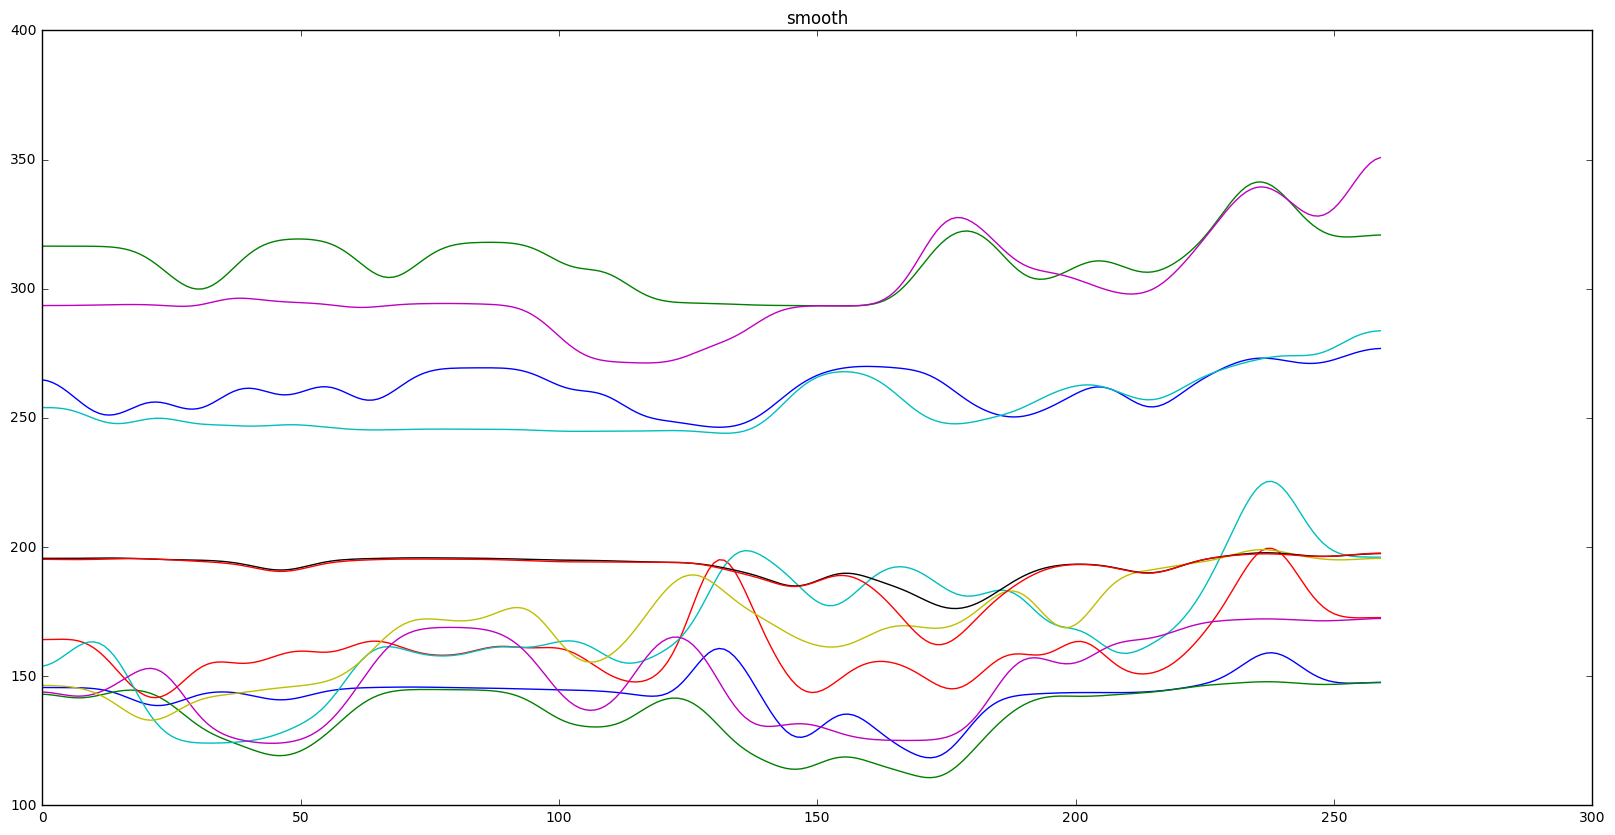

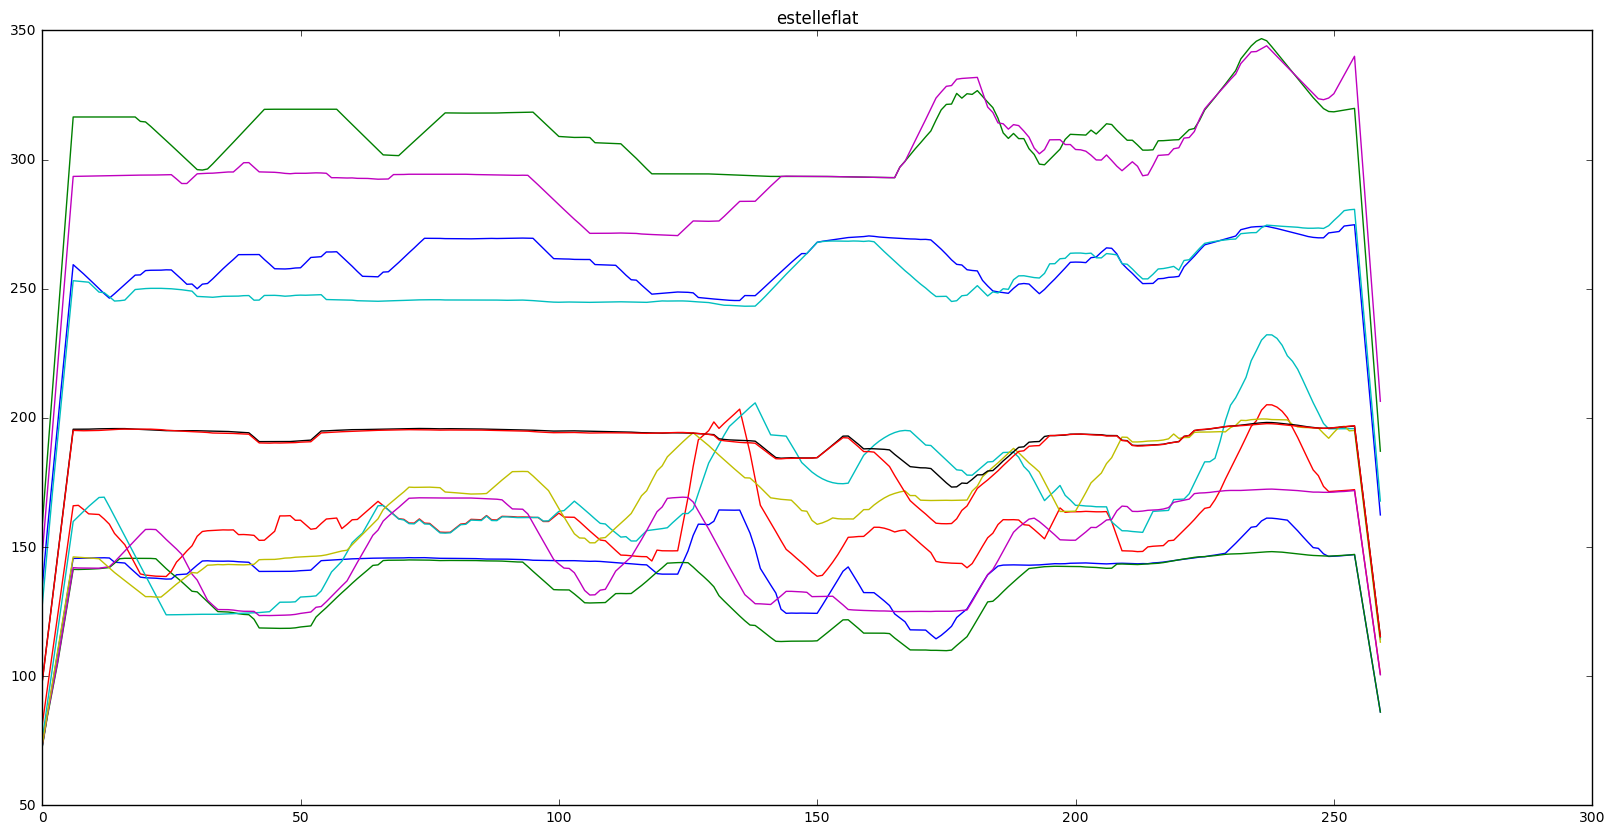

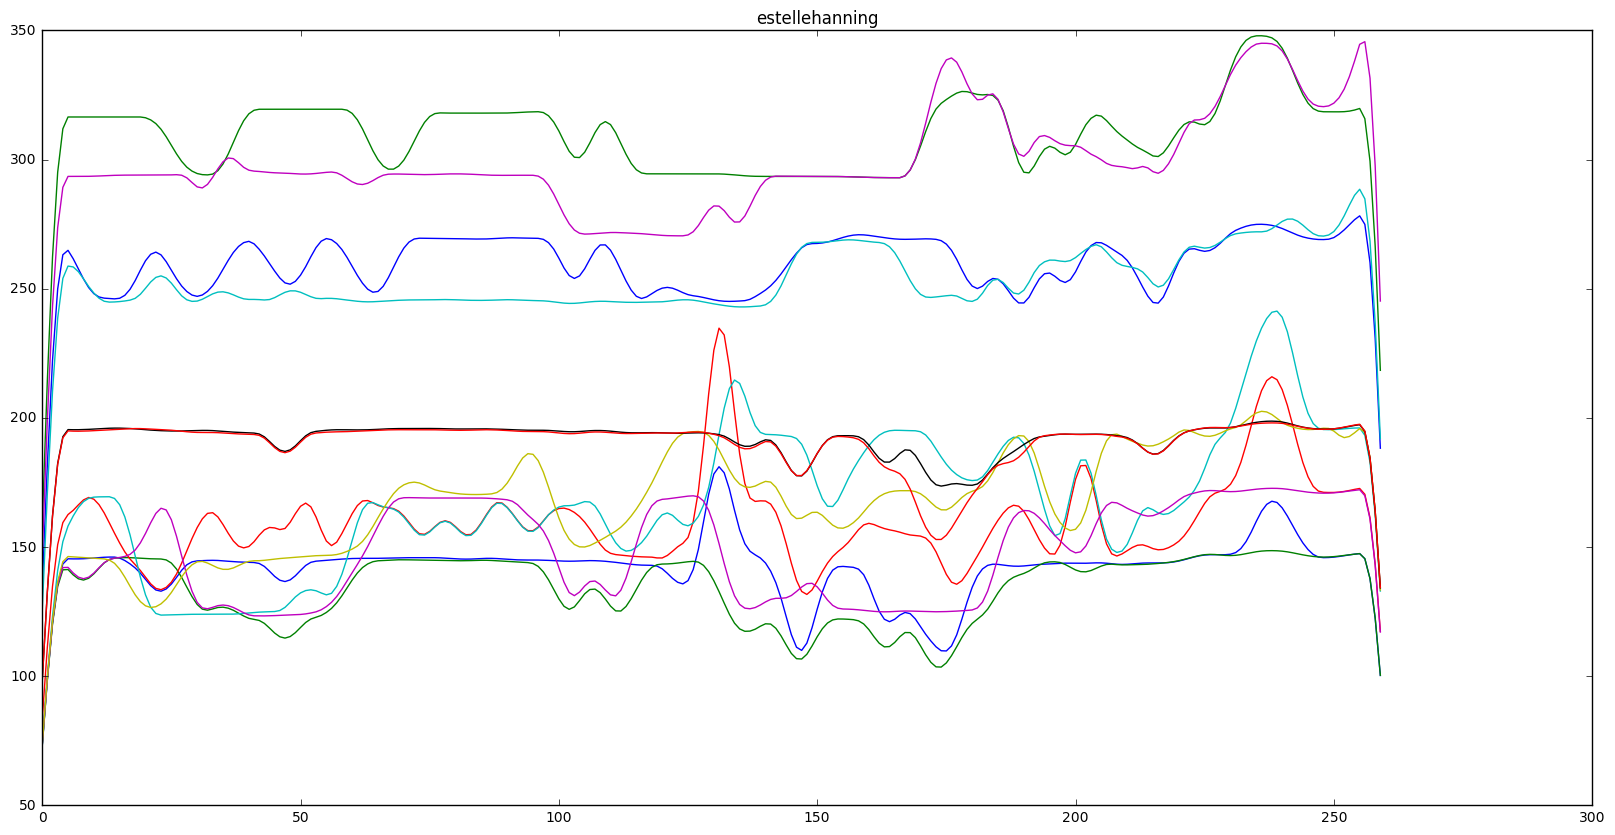

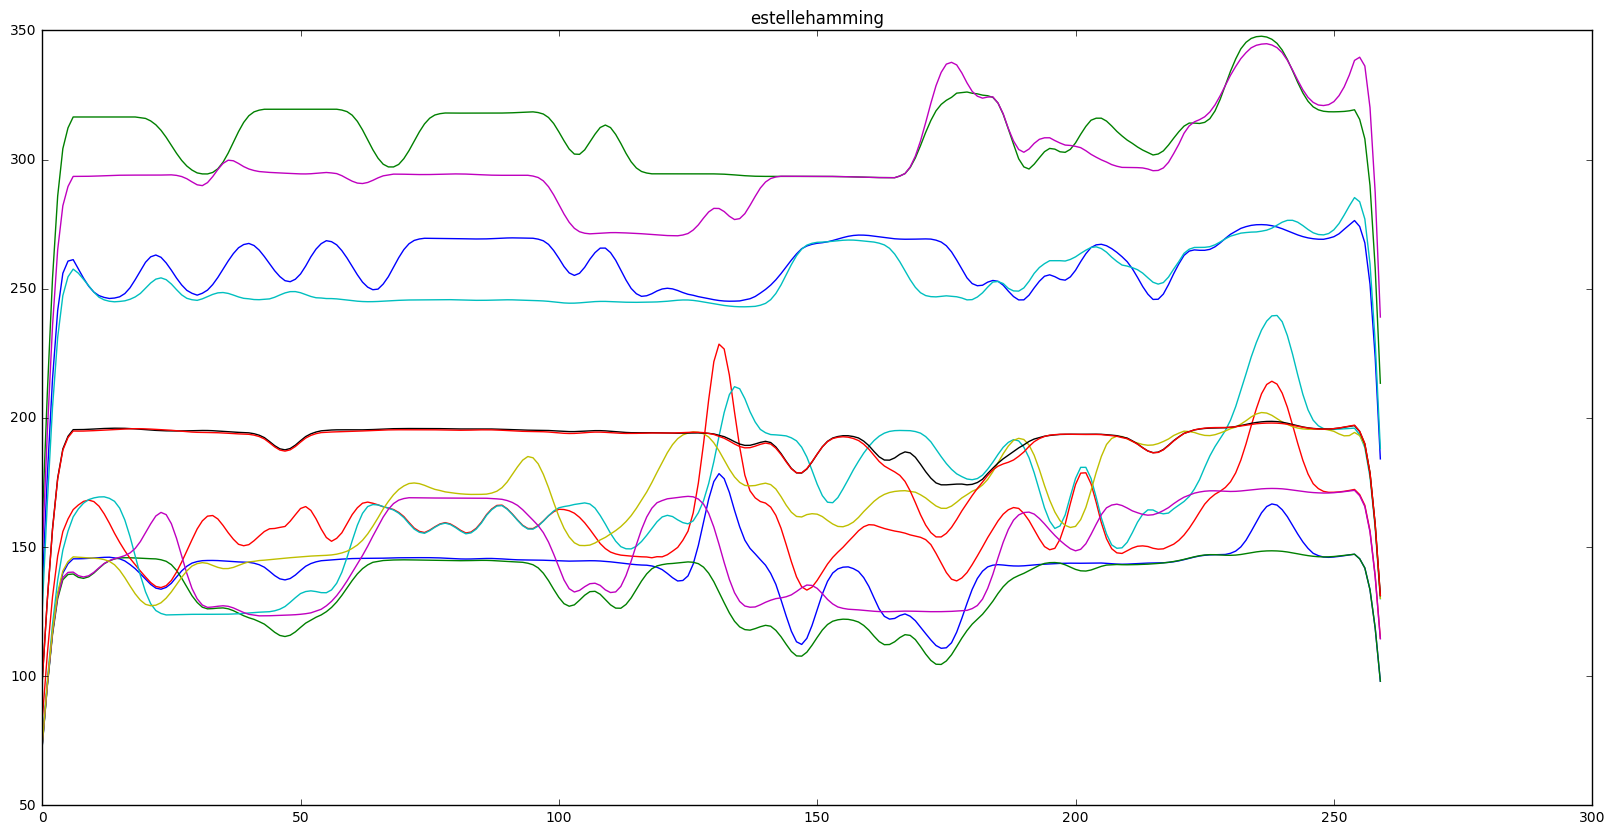

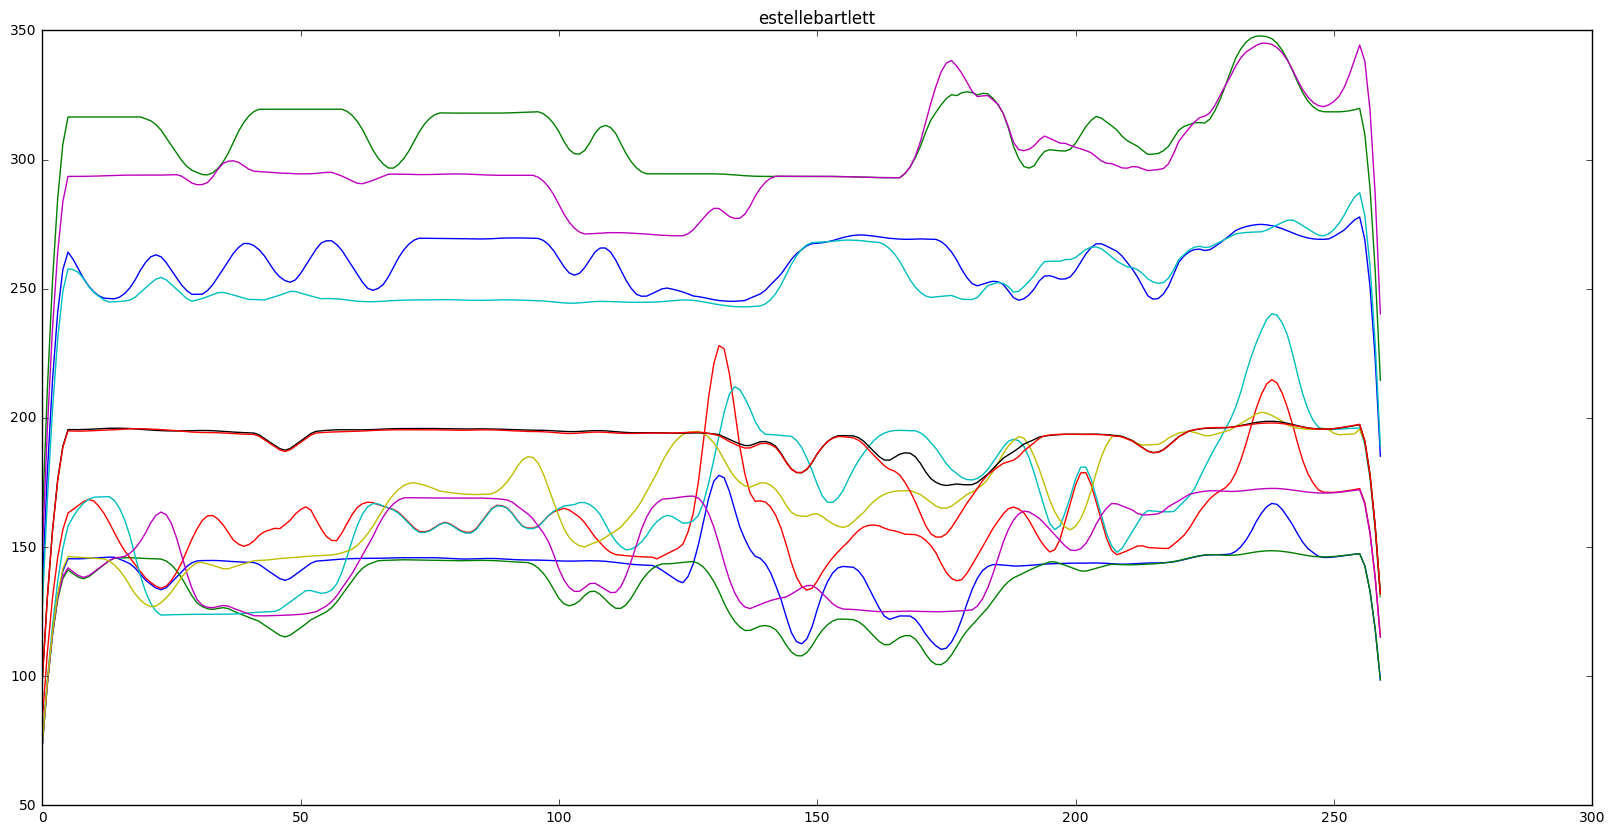

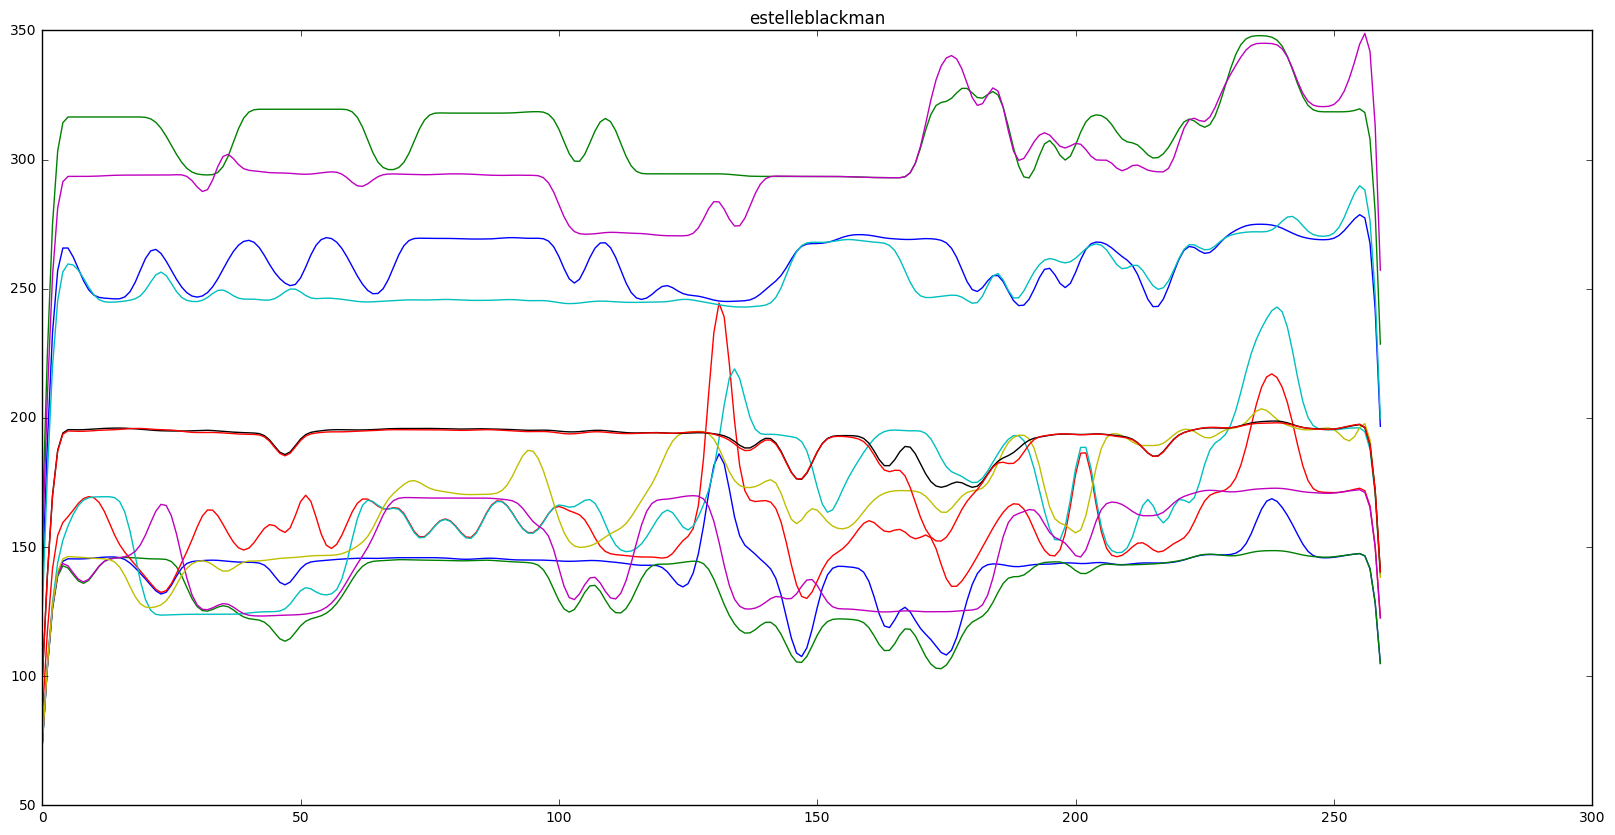

In [49]:
path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/handle_one/"
example = "#28 Bo Hernandez (4)_local.json"

with open(path+example, "r") as infile:
    joint_array = np.array(json.load(infile))
    
inter_list = ["gaussian_filter", "kalmann", "linear"]
print(joint_array.shape)
plot_interpolations(joint_array[:,:12,:], inter_list) #len(joint_array))

# OLD VIDEOS: Test different methods for filtering and filling in missing values:
* Filling in missing values does not work properly
* Tried different filters (Kalmann, Gaussian, Cubic and linear interpolation) to fill in the values and smoothen the curve
* Problem: Sometimes the outliers are actually the right values
* Used LSTM to learn coordinate trajectories to fill in missing values, works but not plotted yet

In [12]:
data = np.load("/Users/ninawiedemann/Desktop/UNI/Praktikum/numpy arrays/unpro_all_coord.npy")[:,:,:12,:]

In [ ]:
joints=["Right shoulder", "Left shoulder", "Right elbow", "Right wrist","Left elbow", "Left wrist",
        "Right hip", "Right knee", "Right ankle", "Left hip", "Left knee", "Left ankle", "Neck ",
        "Right eye", "Right ear","Left eye", "Left ear"]
#print(data[540, 92:95])
def normalize(data):
    M,N, nr_joints,_ = data.shape
    means = np.mean(data, axis = 1)
    std = np.std(data, axis = 1)
    res = np.asarray([(data[:,i]-means)/(std+0.000001) for i in range(len(data[0]))])
    data_new = np.swapaxes(res, 0,1)
    return data_new, means, std

def renormalize(data, means, std, one_pitch=None):
    if one_pitch is None:
        res = np.asarray([data[:,i]*std+means for i in range(len(data[0]))])
        #print(res.shape)
        data_new = np.swapaxes(res, 0,1)
    else:
        print(data.shape)
        data_new = np.asarray([data[i]*std[one_pitch]+means[one_pitch] for i in range(len(data))])
    return data_new

norm, means, std = normalize(data)

inter = 6
DATA_EX =  803 #795 96, 773 96, 796 94, 803 98
FRAME = 98
RANGE = 10
START = FRAME-RANGE
END = FRAME+RANGE
START_JOINT = 0
example = np.array(norm[DATA_EX])


# ML FILL IN
"""
sequ = np.delete(data, FRAME, axis=1)[:, FRAME-10:FRAME+9, :12, :]
sequ = Tools.normalize(sequ)[DATA_EX]
sequ_around = np.reshape(sequ, (1, len(sequ), 24))
print(sequ_around.shape)
ml[FRAME] = np.reshape(get_ML_coord(sequ_around)[0], (12,2))
"""

#print(sequ_around)
plot = ["gaussian_filter", "kalmann", "linear"]

ml = np.load("/Users/ninawiedemann/Desktop/UNI/Praktikum/numpy arrays/ml_predict_all.npy")[DATA_EX]
# print(ml[START:END, 0, 0])

plot_interpolations(example, plot, START, END)

### Get suitable video from harddrive and cf file

In [3]:
from data_preprocess import Preprocessor
DATA_EX = 20
prepro = Preprocessor("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/cf_data.csv")
prepro.remove_small_classes(50)
print(prepro.cf.shape)
print(prepro.cf.iloc[DATA_EX]["Game"])
data = prepro.get_coord_arr()
release = prepro.cf.iloc[DATA_EX]["pitch_frame_index"]
print(release)

path = "/Volumes/Nina Backup/videos/atl/"
#path_input_dat = "/Volumes/Nina Backup/videos/atl/2017-04-14/center field/490251-0f308987-60b4-480c-89b7-60421ab39106.mp4.dat"
dates = "2017-07-16" #, "2017-04-18", "2017-05-02", "2017-05-06"] # , "2017-05-19", "2017-05-23", "2017-06-06", "2017-06-10", "2017-06-18", "2017-06-22", "2017-07-04", "2017-07-16",
# "2017-04-15", "2017-04-19", "2017-05-03", "2017-05-07", "2017-05-20", "2017-05-24", "2017-06-07", "2017-06-11", "2017-06-19", "2017-06-23", "2017-07-05", "2017-07-17"]
# only first two rows von den im cluster angezeigten
# output_folder=args.output_dir
file = prepro.cf.iloc[DATA_EX]["Game"] + ".mp4" #491465-1a697776-fcf9-4a5e-817e-c38f975a6ce8.mp4"

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (253,254,255,256,257,258,259,289) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


csv eingelesen with length  13150
Only Pitcher rows
[['Changeup' 491]
 ['Curveball' 627]
 ['Eephus' 1]
 ['Fastball (2-seam)' 1341]
 ['Fastball (4-seam)' 2075]
 ['Fastball (Cut)' 287]
 ['Fastball (Split-finger)' 49]
 ['Knuckle curve' 73]
 ['Knuckleball' 350]
 ['Sinker' 265]
 ['Slider' 913]
 ['Unknown Pitch Type' 103]]
Removed because not enought class members:  ['Eephus' 'Fastball (Split-finger)'] Unknown Pitch Type
(6422, 444)
490987-689f2927-566f-433d-a1dc-ee52294b8772
94.0


### Plot on video

(6422, 167, 18, 2)


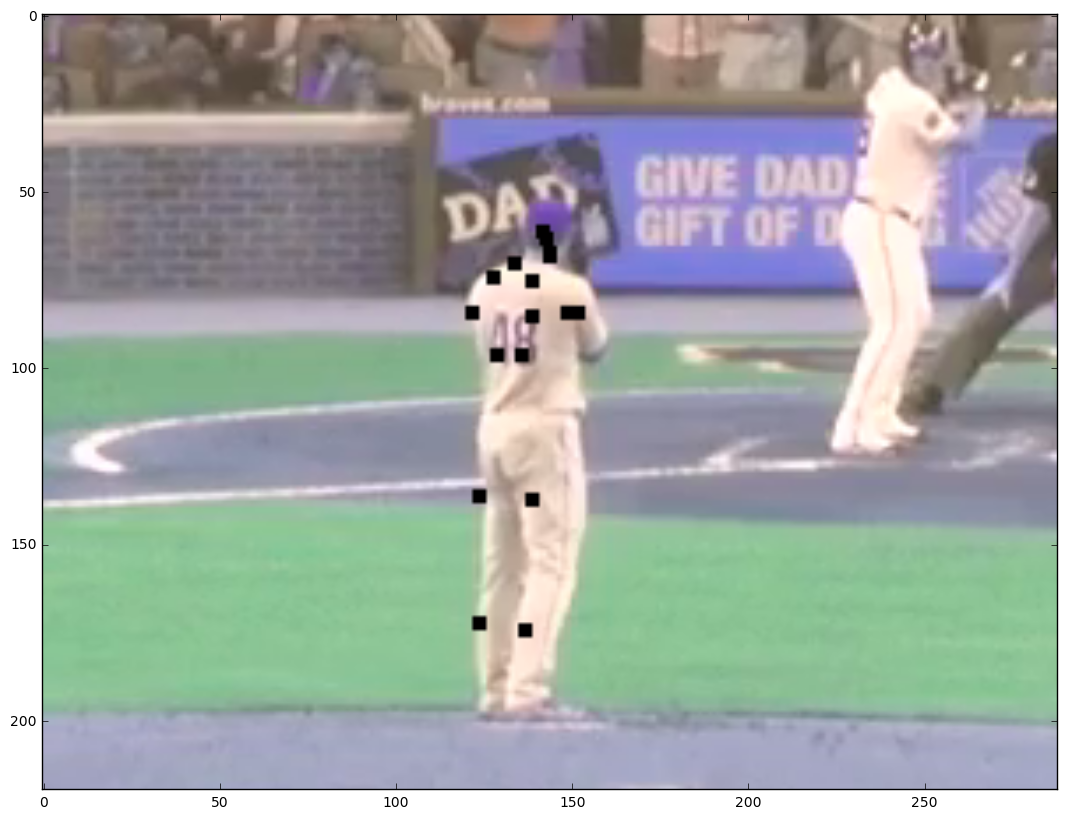

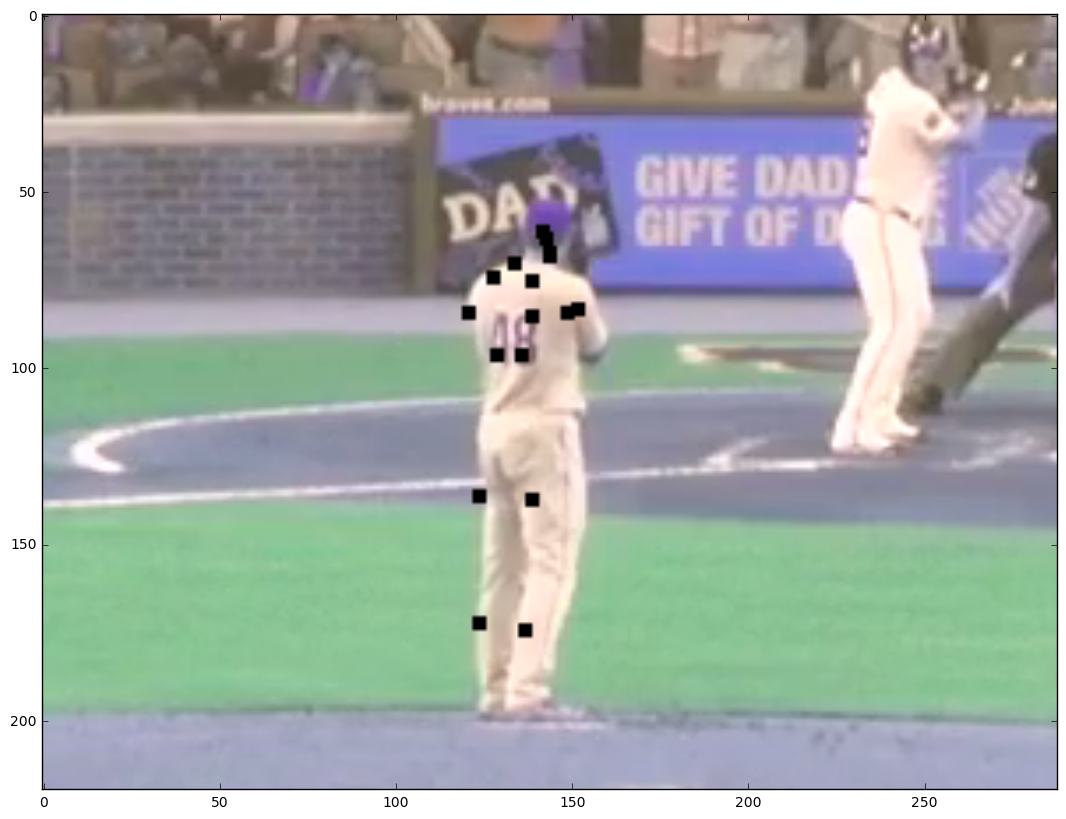

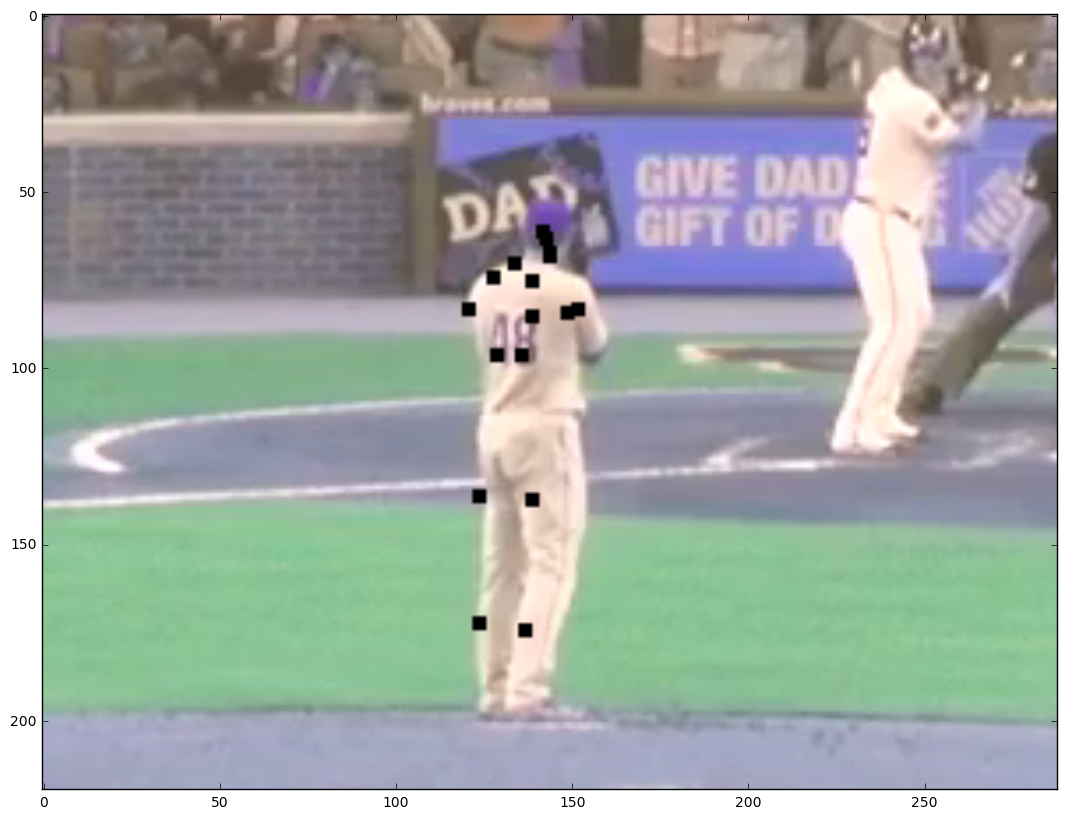

KeyboardInterrupt: 

In [9]:
print(data.shape)
output = []
input_dir = "/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/" #path+dates+"/center field/"
video_capture = cv2.VideoCapture(input_dir+file)
game_id = file[:-4]

for i in open(input_dir+file+".dat").readlines():
    datContent=ast.literal_eval(i)

bottom_p=datContent['Pitcher']['bottom']
left_p=datContent['Pitcher']['left']
right_p=datContent['Pitcher']['right']
top_p=datContent['Pitcher']['top']
bottom_b=datContent['Batter']['bottom']
left_b=datContent['Batter']['left']
right_b=datContent['Batter']['right']
top_b=datContent['Batter']['top']
#center_dic['Pitcher']=np.array([abs(top_p-bottom_p)/2., abs(left_p-right_p)/2.])
#center_dic['Batter']=np.array([abs(top_b-bottom_b)/2., abs(left_b-right_b)/2.])
#frames = np.zeros((167, 221, 290, 3))
i = 0
while True:
    ret, frame = video_capture.read()
    if frame is None:
        break
    pitcher = frame[top_p:bottom_p, left_p:right_p]
    # batter = frame[top_b:bottom_b, left_b:right_b]
    #frames[i]= pitcher
    #for i in range(len(data[0])):
    plt.figure(figsize = (20,10))
    for j in range(18):
        x = data[DATA_EX, i, j, 0]
        y = data[DATA_EX, i, j, 1]
        pitcher[int(x)-2:int(x)+2, int(y)-2:int(y)+2]=[1,0,0]
    plt.imshow(pitcher)
    plt.show()
    i+=1

#output.append(frames)

(167, 12, 2)
(167, 12, 2)
(167, 12, 2)
(167, 221, 290, 3)
91.0
88


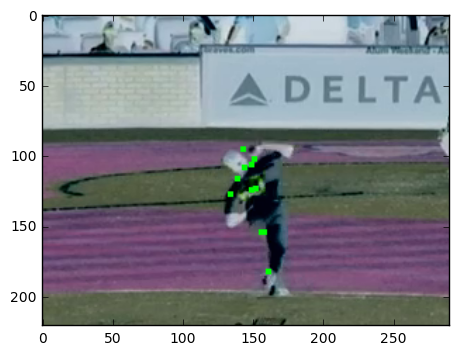

89


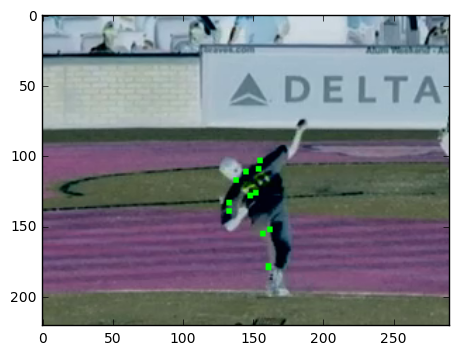

90


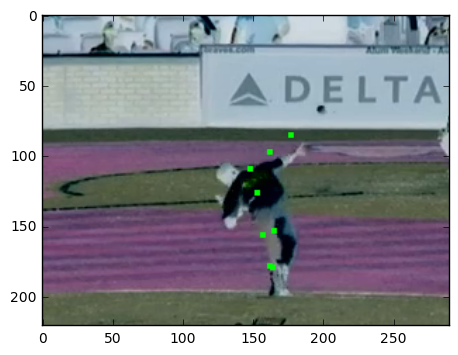

91
BALL RELEASE FRAME


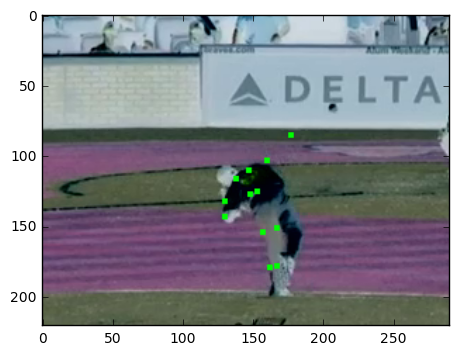

92


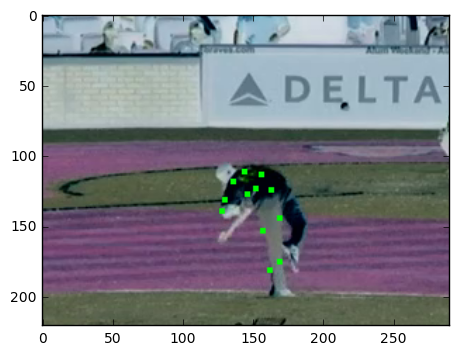

93


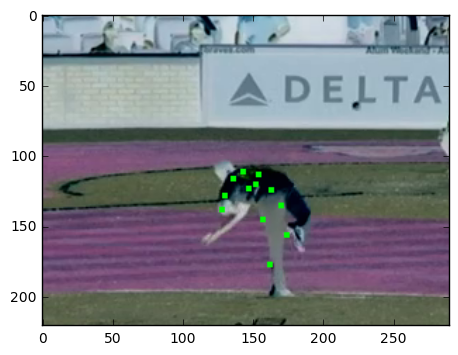

94


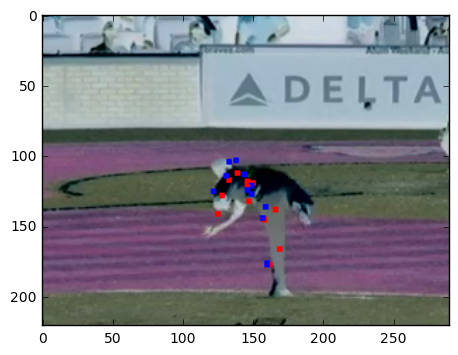

95


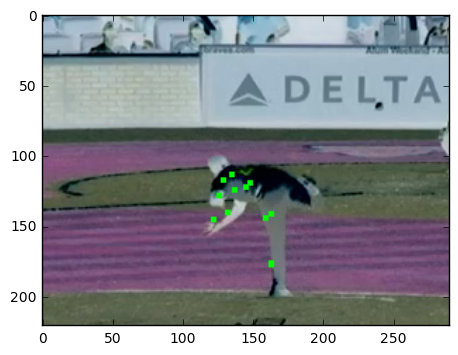

96


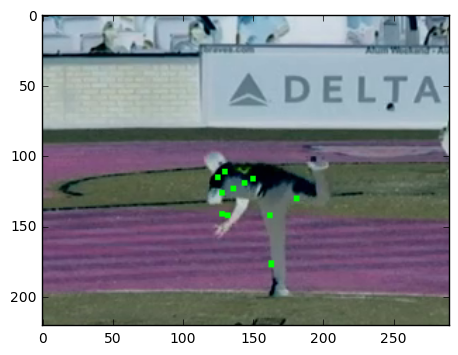

97


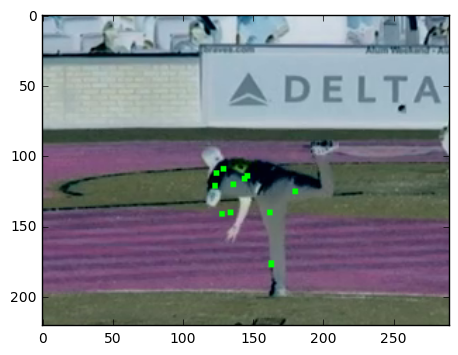

98


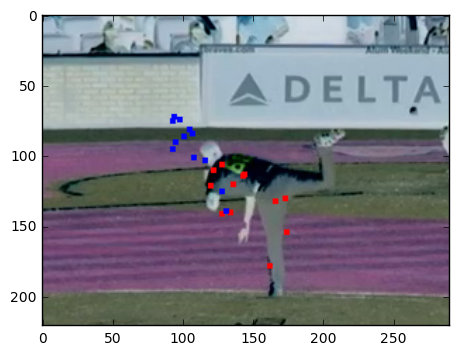

99


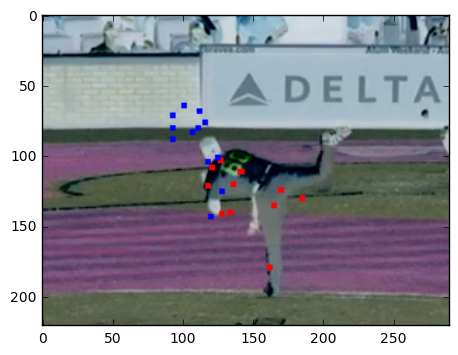

100


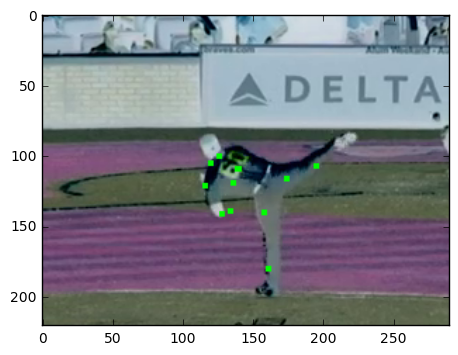

101


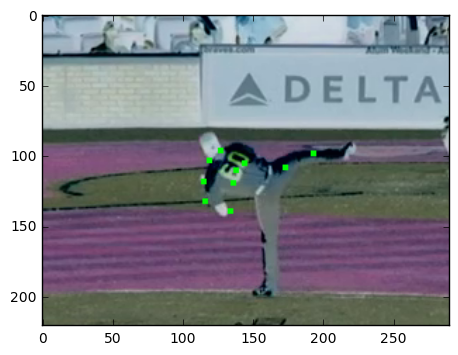

102


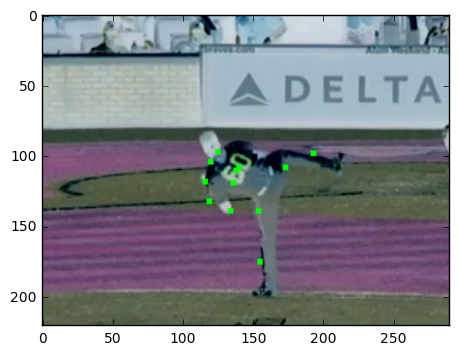

103


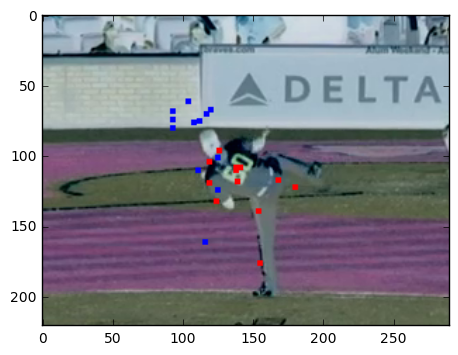

104


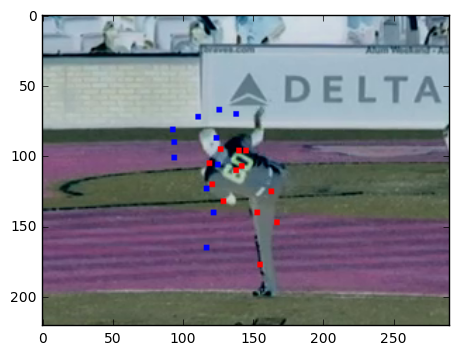

105


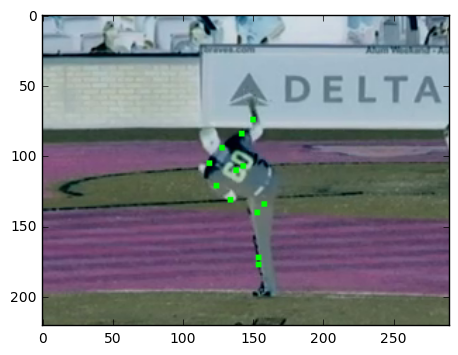

106


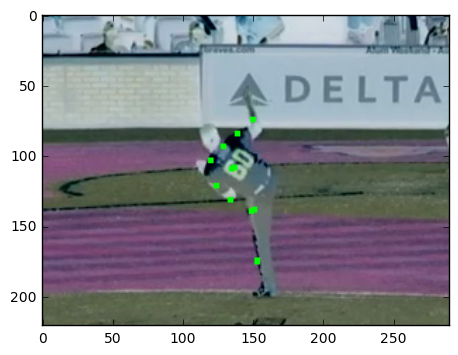

107


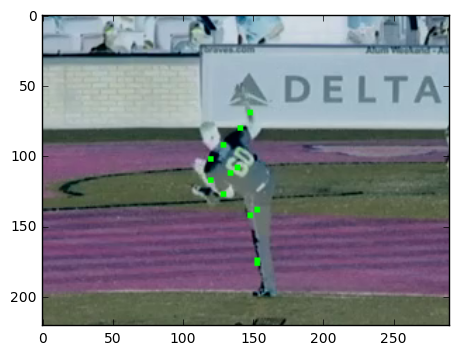

In [26]:
""" RED POINTS ARE SMOOTHED, GREEN UNPROCESSED"""

linear = renormalize(linear, means, std, one_pitch = DATA_EX)
ml = renormalize(ml, means, std, one_pitch = DATA_EX)
example = renormalize(example, means, std, one_pitch = DATA_EX)

vid = output[0]
print(vid.shape)
print(release)
for i in range(START, END):
    print(i)
    if i==release:
        print("BALL RELEASE FRAME")
    for j in range(12):
        x = linear[i, j, 0]
        y = linear[i,j,1]
        vid[i,int(x)-2:int(x)+2, int(y)-2:int(y)+2]=[1,0,0] # red
        x = ml[i, j, 0]
        y = ml[i,j,1]
        vid[i,int(x)-2:int(x)+2, int(y)-2:int(y)+2]=[0,0,1] # blue
        x = example[i, j, 0]
        y = example[i,j,1]
        vid[i,int(x)-2:int(x)+2, int(y)-2:int(y)+2]=[0,1,0] # green : normal
    plt.imshow(vid[i])
    plt.show()

### Kalmann filtering test

In [76]:
bsp_sequ_x = linear[START:END, 3, 0]
bsp_sequ_y = linear[START:END, 3, 1]
print(len(bsp_sequ_x))

"""plt.figure()
plt.plot(bsp_sequ_x, bsp_sequ_y, label = "before_filtering")
plt.show()"""

plt.rcParams['figure.figsize'] = (10, 8)

zx, xhatnew = kalmann(bsp_sequ_x)
zy, yhat = kalmann(bsp_sequ_y)

plt.figure()
plt.plot(zx,'k+',label='noisy measurements')
plt.plot(xhatnew,'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('x_coord')
plt.show()

plt.figure()
plt.plot(zy,'k+',label='noisy measurements')
plt.plot(yhat,'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('y_coord')
plt.show()

plt.figure()
plt.plot(bsp_sequ_x, bsp_sequ_y,'k-',label='noisy measurements')
plt.plot(xhatnew, yhat, 'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

NameError: name 'linear' is not defined

In [53]:
with open("Pose_Estimation/release_frame_new_cf.json", "r") as infile:
    dic = json.load(infile)

In [ ]:
a = list(dic.keys())
b = np.zeros(len(a))
i=0
for play in a:
    b[i]=dic[play]
    i+=1

In [56]:
d = {"play_id":a, "pitch_frame_index":b}
df = pd.DataFrame(data=d)

In [57]:
df.to_csv("Pose_Estimation/release_frame_new_cf.csv")

In [59]:
a = pd.read_csv("Pose_Estimation/BOS_SV_metadata.csv")
print(a.columns.tolist())
b = a.rename(columns = {"pitch_type": "Pitch Type"})
print(b.columns.tolist())

['Unnamed: 0', 'Batter', 'Pitcher', 'batter_mlb_id', 'catcher_mlb_id', 'first_movement_frame_index', 'first_movement_frame_offset_in_msec', 'pitch_frame_index', 'pitch_frame_offset_in_msec', 'pitch_type', 'pitcher_mlb_id', 'play_id', 'strike_zone_frame_url']
['Unnamed: 0', 'Batter', 'Pitcher', 'batter_mlb_id', 'catcher_mlb_id', 'first_movement_frame_index', 'first_movement_frame_offset_in_msec', 'pitch_frame_index', 'pitch_frame_offset_in_msec', 'Pitch Type', 'pitcher_mlb_id', 'play_id', 'strike_zone_frame_url']


In [60]:
b.to_csv("Pose_Estimation/BOS_SV_metadata.csv")

In [62]:
def func1(): 
    return 0
for i in range(1):
    x = eval("func"+str(i+1))()

0
